In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 as cv
import tensorflow
import glob

In [2]:
from tensorflow.keras.models import load_model
autoencoder = load_model(r"C:\Users\physicx\Documents\shubham\checkerboard\trial_error_checkerboard_train8.h5")

In [3]:
left_frame_folder = glob.glob(r'C:\Users\physicx\Documents\shubham\3dreconstruction\3d_outputs\9-05-23\camcalibnew-main\090523 checkerboard 2\left/*.png')
right_frame_folder = glob.glob(r'C:\Users\physicx\Documents\shubham\3dreconstruction\3d_outputs\9-05-23\camcalibnew-main\090523 checkerboard 2\right/*.png')
def calibrate_camera(left_frame_folder,right_frame_folder):
    left_names = left_frame_folder
    right_names = right_frame_folder
    images_left = []
    for imname in left_names:
        im = cv.imread(imname, 1)
        images_left.append(im)
    images_right = []
    for imname in right_names:
        im = cv.imread(imname, 1)
        images_right.append(im)

    #criteria used by checkerboard pattern detector.
    #Change this if the code can't find the checkerboard
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    rows = 6 #number of checkerboard rows.
    columns = 7 #number of checkerboard columns.
    world_scaling = 1. #change this to the real world square size. Or not.
    
    #coordinates of squares in the checkerboard world space
    objp = np.zeros((6 * 7, 3), np.float32)
    objp[:, :2] = np.mgrid[0:rows, 0:columns].T.reshape(-1, 2)
    objp = objp * 4.235
    

    #frame dimensions. Frames should be the same size.
    width = images_left[0].shape[1]
    height = images_left[0].shape[0]
    
    width_r = images_right[0].shape[1]
    height_r = images_right[0].shape[0]
    #Pixel coordinates of checkerboards
    imgpoints_left = [] # 2d points in image plane.
    imgpoints_right = []

    #coordinates of the checkerboard in checkerboard world space.
    objpoints = [] # 3d point in real world space


    imcount = 1
    for frame in zip(images_left,images_right):
        gray1 = cv.cvtColor(frame[0], cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(frame[1], cv.COLOR_BGR2GRAY)

        
        #find the checkerboard
        ret1, corners1 = cv.findChessboardCorners(gray1, (rows, columns),  cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)
        ret2, corners2 = cv.findChessboardCorners(gray2, (rows, columns),  cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)
        if ret1 == True and ret2 == True:

            #Convolution size used to improve corner detection. Don't make this too large.
            conv_size = (11, 11)

            #opencv can attempt to improve the checkerboard coordinates
            corners1 = cv.cornerSubPix(gray1, corners1, conv_size, (-1, -1), criteria)
            corners2 = cv.cornerSubPix(gray2, corners2, conv_size, (-1, -1), criteria)
            img_left1 = cv.drawChessboardCorners(frame[0], (rows,columns), corners1, ret1)
            cv.imwrite(r"C:\Users\physicx\Documents\shubham\3dreconstruction\corner\left_image/"+str(imcount)+r".png", img_left1)
            img_right1 = cv.drawChessboardCorners(frame[1], (rows,columns), corners2, ret2)
            cv.imwrite(r"C:\Users\physicx\Documents\shubham\3dreconstruction\corner\right_image/"+str(imcount)+r".png", img_right1)
            imcount = imcount+1
            objpoints.append(objp)
            imgpoints_left.append(corners1)
            imgpoints_right.append(corners2)


    ret1, mtx1, dist1, rvecs1, tvecs1 = cv.calibrateCamera(objpoints, imgpoints_left, (1440, 1080), None, None)
    print('rmse1:', ret1)
    print('camera matrix1:\n', mtx1)
    print('distortion coeffs1:', dist1)
    print('Rs1:\n', rvecs1)
    print('Ts1:\n', tvecs1)
    
    #reprojection error
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints21, _ = cv.projectPoints(objpoints[i], rvecs1[i], tvecs1[i], mtx1, dist1)
        error = cv.norm(imgpoints_left[i], imgpoints21, cv.NORM_L2)/len(imgpoints21)
        mean_error += error
    print( "total error left frame: {}".format(mean_error/len(objpoints)))

    ret2, mtx2, dist2, rvecs2, tvecs2 = cv.calibrateCamera(objpoints, imgpoints_right, (1440, 1080), None, None)
    print('rmse2:', ret2)
    print('camera matrix2:\n', mtx2)
    print('distortion coeffs2:', dist2)
    print('Rs2:\n', rvecs2)
    print('Ts2:\n', tvecs2)
    
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints22, _ = cv.projectPoints(objpoints[i], rvecs2[i], tvecs2[i], mtx2, dist2)
        error = cv.norm(imgpoints_right[i], imgpoints22, cv.NORM_L2)/len(imgpoints22)
        mean_error += error
    print( "total error right frame: {}".format(mean_error/len(objpoints)))
#     print(imgpoints_left,imgpoints_right)
    return mtx1, dist1, mtx2, dist2,img_left1,img_right1

mtx1, dist1, mtx2, dist2, img_left1,img_right1= calibrate_camera(left_frame_folder,right_frame_folder)

rmse1: 0.5383092743594245
camera matrix1:
 [[2.33425717e+03 0.00000000e+00 6.33903006e+02]
 [0.00000000e+00 2.31691824e+03 4.90806759e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coeffs1: [[-8.11832855e-02  3.20374277e-01  7.29784822e-04 -1.52763747e-02
  -1.06306373e+00]]
Rs1:
 (array([[ 0.16114262],
       [-0.19065063],
       [-1.54994867]]), array([[ 0.14942682],
       [-0.18111686],
       [-1.53833771]]), array([[ 0.15852435],
       [-0.18423776],
       [-1.55070154]]), array([[ 0.15515648],
       [-0.1804075 ],
       [-1.51708739]]), array([[ 0.15526581],
       [-0.18560534],
       [-1.52879775]]), array([[ 0.17158989],
       [-0.22205064],
       [-1.55948906]]), array([[-0.04762945],
       [ 0.0258535 ],
       [-1.5669855 ]]), array([[ 0.03846872],
       [ 0.04999805],
       [-1.58634303]]), array([[-0.03409775],
       [ 0.02768037],
       [-1.60597472]]), array([[-0.00921213],
       [ 0.03273062],
       [-1.66565853]]), array([[ 0.15100906

In [4]:
frames_folder = r"C:\Users\physicx\Documents\shubham\3dreconstruction\3d_outputs\9-05-23\camcalibnew-main\090523 checkerboard 2\left/*"
frames_folder1 = r"C:\Users\physicx\Documents\shubham\3dreconstruction\3d_outputs\9-05-23\camcalibnew-main\090523 checkerboard 2\right/*"
def stereo_calibrate(mtx1, dist1, mtx2, dist2, frames_folder,frames_folder1):
    #read the synched frames
    images_names1 = glob.glob(frames_folder)
    images_names2 = glob.glob(frames_folder1)
    c1_images_names = images_names1[0:]
    c2_images_names = images_names2[0:]
 
    c1_images = []
    c2_images = []
    for im1, im2 in zip(c1_images_names, c2_images_names):
        _im = cv.imread(im1, 1)
        c1_images.append(_im)
 
        _im = cv.imread(im2, 1)
        c2_images.append(_im)
 
    #change this if stereo calibration not good.
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
    rows = 6 #number of checkerboard rows.
    columns = 7 #number of checkerboard columns.
    world_scaling = 1. #change this to the real world square size. Or not.
 
    #coordinates of squares in the checkerboard world space
    objp = np.zeros((rows*columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
    objp = 4.235 * objp
 
    #frame dimensions. Frames should be the same size.
    width = c1_images[0].shape[1]
    height = c1_images[0].shape[0]
 
    #Pixel coordinates of checkerboards
    imgpoints_left = [] # 2d points in image plane.
    imgpoints_right = []
 
    #coordinates of the checkerboard in checkerboard world space.
    objpoints = [] # 3d point in real world space
    
    R1=[]
    T1=[]
    
    for frame1, frame2 in zip(c1_images, c2_images):
        gray1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
        
        
        c_ret1, corners1 = cv.findChessboardCorners(gray1, (rows, columns), cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)
        c_ret2, corners2 = cv.findChessboardCorners(gray2, (rows, columns), cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)

        if c_ret1 == True and c_ret2 == True:
            corners1 = cv.cornerSubPix(gray1, corners1, (11, 11), (-1, -1), criteria)
            corners2 = cv.cornerSubPix(gray2, corners2, (11, 11), (-1, -1), criteria)

            cv.drawChessboardCorners(frame1, (rows,columns), corners1, c_ret1)
#             cv.imshow('img', frame1)

            cv.drawChessboardCorners(frame2, (rows,columns), corners2, c_ret2)
#             cv.imshow('img2', frame2)
#             cv.waitKey(0)
#             cv.destroyAllWindows()
            objpoints.append(objp)
            imgpoints_left.append(corners1)
            imgpoints_right.append(corners2)

            stereocalibration_flags = cv.CALIB_FIX_INTRINSIC
            ret, CM1, dist1, CM2, dist2, R, T, E, F = cv.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, mtx1, dist1,mtx2, dist2, (width, height), criteria = criteria, flags = stereocalibration_flags)
#                 print(R)
#                 print(T)

            R1.append(R)
            T1.append(T)
#             print(R1)
#             print(T1)
#         print(ret)
    return ret,R1,T1

ret,R,T = stereo_calibrate(mtx1, dist1, mtx2, dist2, frames_folder,frames_folder1)

In [5]:
ret

1.034301605928372

In [6]:
import pytictoc

In [1103]:

autoencoder_vein = load_model("C:/Users/physicx/Documents/shubham/server output h5 file/trial_error_vein_train12.h5")
h1,  w1 = img_left1.shape[:2]
h2,  w2 = img_right1.shape[:2]


newcameramtx1, roi  = cv.getOptimalNewCameraMatrix(mtx1, dist1, (w1,h1), 1, (w1, h1))
img_vein = cv.imread(r"C:\Users\physicx\Documents\shubham\3dreconstruction\3d_outputs\10-05-23\camcalibnew-main\09_05_23\Left_shubham3850nm.png",0)
left_corrected = cv.undistort(img_vein,mtx1,dist1,None,newcameramtx1)
# cv.imwrite('left_corrected.png', left_corrected)
image_left_corrected = left_corrected.reshape((1,1080, 1440,1)).astype('float32') / 255.
prediected_left = autoencoder_vein.predict(image_left_corrected)
prediected_left = (prediected_left.reshape((1080, 1440)) * 255 ).astype('uint8')
# cv.imwrite("prediected_left.png",prediected_left)

clahe = cv.createCLAHE(clipLimit = 2.0, tileGridSize=(5,5))
cl_img1 = clahe.apply(left_corrected)

newcameramtx2, roi = cv.getOptimalNewCameraMatrix(mtx2, dist2, (w2,h2), 1, (w2,h2))
img_vein = cv.imread(r"C:\Users\physicx\Documents\shubham\3dreconstruction\3d_outputs\10-05-23\camcalibnew-main\09_05_23\Right_shubham3850nm.png",0)
right_corrected = cv.undistort(img_vein,mtx2,dist2,None,newcameramtx2)
# cv.imwrite('Right_corrected.png', right_corrected)
image_right_corrected = right_corrected.reshape((1,1080, 1440,1)).astype('float32') / 255.
prediected_right = autoencoder_vein.predict(image_right_corrected)
prediected_right = (prediected_right.reshape((1080, 1440)) * 255 ).astype('uint8')
# cv.imwrite("prediected_right.png",prediected_right)

cl_img2 = clahe.apply(right_corrected)

1/1 [==============================] - 1s 568ms/step


In [1104]:
# clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(5,5))
# cl_img1 = clahe.apply(left_corrected)
# cl_img2 = clahe.apply(right_corrected)

In [1105]:
# plt.imshow(cl_img1,cmap = 'gray')

In [1106]:
# plt.imshow(cl_img2,cmap = 'gray')

In [1107]:
# cl_img1 = cv.imread(r"C:\Users\physicx\Documents\shubham\3dreconstruction\3d_outputs\10-05-23\camcalibnew-main\vein_images\Left_Vein01850nm.png",0) 
# cl_img2 = cv.imread(r"C:\Users\physicx\Documents\shubham\3dreconstruction\3d_outputs\10-05-23\camcalibnew-main\vein_images\Right_Vein01850nm.png",0)

In [1108]:
thresh1 = cv.GaussianBlur(prediected_left,(25,25),0)
thresh2 = cv.GaussianBlur(prediected_right,(25,25),0)

thresh1 = cv.adaptiveThreshold(thresh1, 255, cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV, 255, 100)
thresh2 = cv.adaptiveThreshold(thresh2, 255, cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV, 255, 100)
cv.imwrite('threshold_left_corrected.png',thresh1)
cv.imwrite('threshold_right_corrected.png',thresh2)

True

In [1109]:
import random
import cv2 as cv

def add_noise(img):

    row , col = img.shape

    number_of_pixels = random.randint(300, 10000)
    for i in range(number_of_pixels):
    
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)

        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)

        img[y_coord][x_coord] = 255
    
    # Randomly pick some pixels in
    # the image for coloring them black
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300 , 10000)
    for i in range(number_of_pixels):
    
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)

        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)

        # Color that pixel to black
        img[y_coord][x_coord] = 0
    
    return img

# salt-and-pepper noise can
# be applied only to grayscale images
# Reading the color image in grayscale image
# img = cv2.imread('lena.jpg',cv.IMREAD_GRAYSCALE)

#Storing the image
thresh2 = add_noise(thresh2)
cv.imwrite('salt-and-pepper-lena.jpg',add_noise(thresh2))

True

In [1110]:
scale = 1
widthl = int(thresh1.shape[1]/scale)
heightl = int(thresh1.shape[0]/scale)
diml = (widthl, heightl)
img1 = cv.resize(thresh1, diml, cv.INTER_AREA)

widthr = int(thresh2.shape[1]/scale)
heightr = int(thresh2.shape[0]/scale)
dimr = (widthr, heightr)
img2 = cv.resize(thresh2, dimr, cv.INTER_AREA)

In [1111]:
orb = cv.ORB_create(edgeThreshold = 18)
KeyPoints1, des1 = orb.detectAndCompute(img1, None)
KeyPoints2, des2 = orb.detectAndCompute(img2, None)

bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck= True)
matches = bf.match(des1, des2)
len(matches)


matches = sorted(matches, key = lambda x:x.distance)

i = 20
# for m in matches[i-5:i+10]:
#     print(m)
#     print(m.distance)

In [1112]:
len(matches)

70

In [1113]:
matching_result = cv.drawMatches(img1, KeyPoints1, img2, KeyPoints2, matches, None, flags=2)

In [1114]:
matches

[< cv2.DMatch 000002131A8DAB90>,
 < cv2.DMatch 000002130FBEC270>,
 < cv2.DMatch 000002130FBEC670>,
 < cv2.DMatch 000002130FBEC390>,
 < cv2.DMatch 000002130FBEC1D0>,
 < cv2.DMatch 000002130FBEC2D0>,
 < cv2.DMatch 000002130FBEC490>,
 < cv2.DMatch 000002130FBEC050>,
 < cv2.DMatch 000002130FBEC430>,
 < cv2.DMatch 000002130FBECF50>,
 < cv2.DMatch 000002130FBEC9B0>,
 < cv2.DMatch 000002130FBECE30>,
 < cv2.DMatch 000002130FBEC6F0>,
 < cv2.DMatch 000002130FBECB90>,
 < cv2.DMatch 000002130FBECF70>,
 < cv2.DMatch 000002130826AE90>,
 < cv2.DMatch 000002130FBECF90>,
 < cv2.DMatch 000002130FBECD10>,
 < cv2.DMatch 000002130FBEC070>,
 < cv2.DMatch 000002130FBECAB0>,
 < cv2.DMatch 000002130FBEC0D0>,
 < cv2.DMatch 000002130FBEC2B0>,
 < cv2.DMatch 000002130FBECDB0>,
 < cv2.DMatch 000002131A829030>,
 < cv2.DMatch 000002130FBEC790>,
 < cv2.DMatch 000002130FBEC870>,
 < cv2.DMatch 000002130FBECAD0>,
 < cv2.DMatch 000002130FBEC150>,
 < cv2.DMatch 000002130FBEC630>,
 < cv2.DMatch 000002130FBECA90>,
 < cv2.DMa

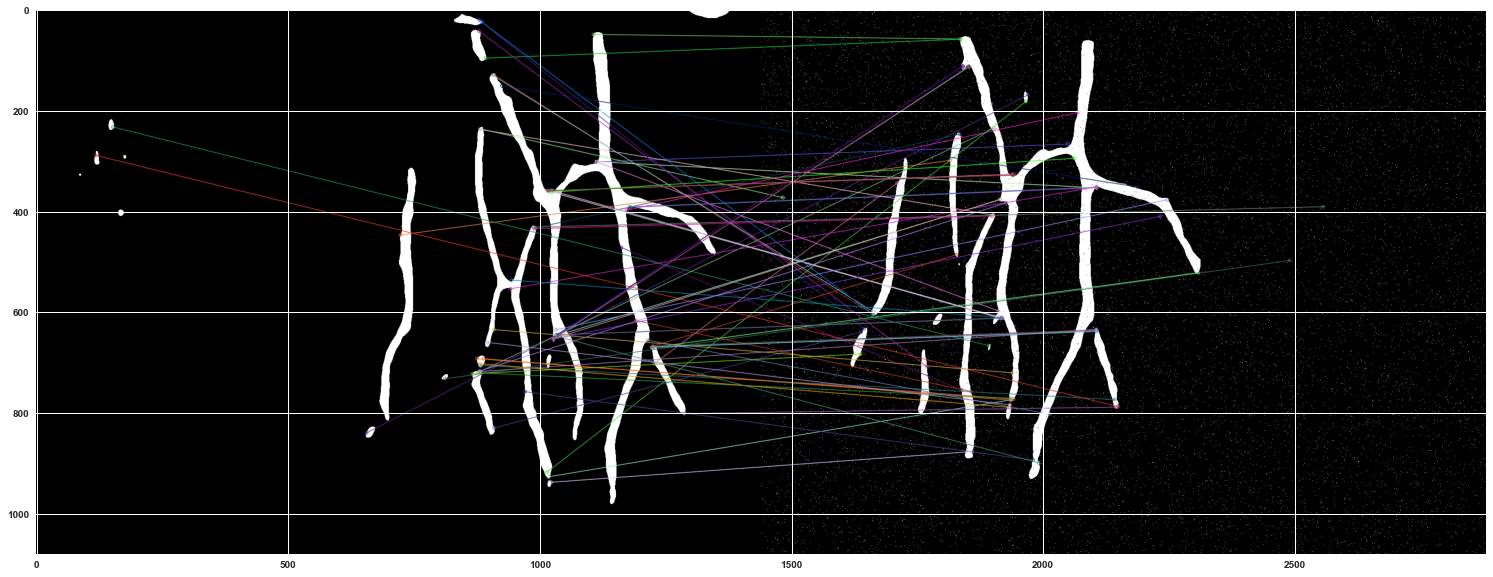

In [1115]:
plt.figure(figsize=(30,10))
plt.imshow(matching_result,cmap = 'gray')
plt.savefig('keypoint_match.png')

In [1116]:

p1=[]
p2=[]
for match in matches[i-15:i+30]:
    p1.append([KeyPoints1[match.queryIdx].pt])
    p2.append([KeyPoints2[match.trainIdx].pt])

    
p1 = np.array(p1)
p2 = np.array(p2)

p1 = p1.reshape(p1.shape[0],2)
p2 = p2.reshape(p2.shape[0],2)


In [1117]:
H,status = cv.findHomography(p1*scale, p2*scale, cv.RANSAC,22)

In [1118]:
a = np.where((thresh1==255))
# [200:600,600:1200]
pa = []
for i in range(len(a[0])):
    p32 = (a[0][i],a[1][i])
#     print(p32)
    pa.append(p32)
pa = np.array(pa)
# pa

pa_h = []
for i in range(len(a[0])):
    pa_h32 = np.dot(H,(a[0][i],a[1][i], 1))
    pa_h32 = (pa_h32[0],pa_h32[1])
#     print(pa_h32)
    pa_h.append(pa_h32)
pa_h = np.asarray(pa_h)

True

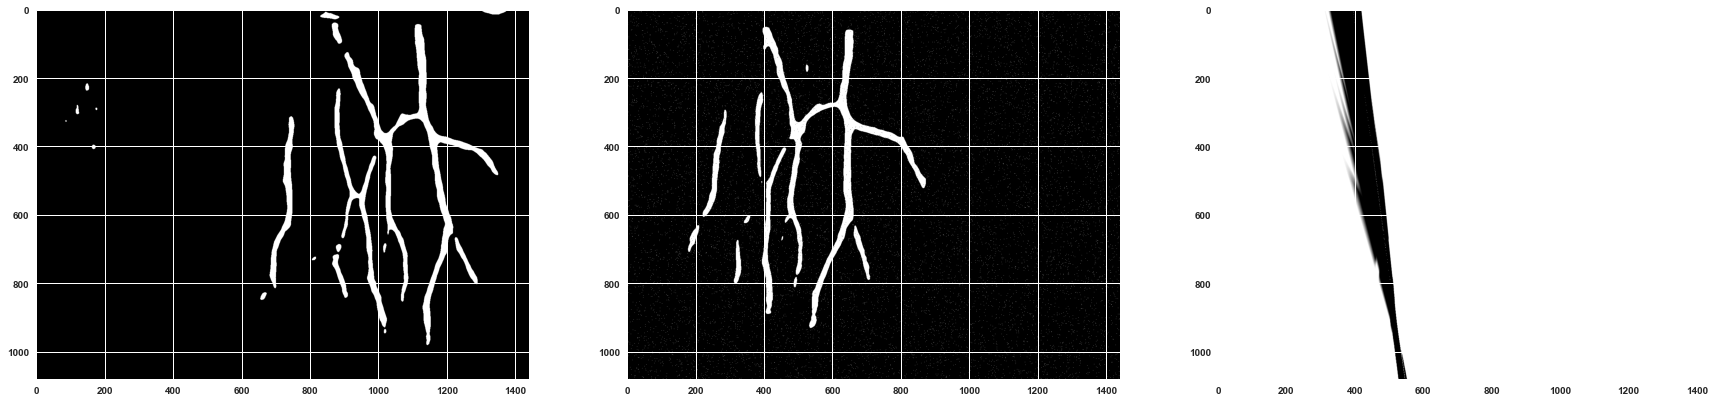

In [1119]:
im_out = cv.warpPerspective(thresh1,H,(thresh1.shape[1],thresh1.shape[0]))
# t.toc()
plt.figure(figsize=(30,10))

ax = plt.subplot(1,3,1)
plt.imshow(thresh1,cmap='gray')
cv.imwrite("left_corrected.png",thresh1)
# target image

ax = plt.subplot(1,3,2)
plt.imshow(thresh2,cmap='gray')
cv.imwrite("thresh2.png",thresh2)
ax = plt.subplot(1,3,3)
plt.imshow(im_out,cmap='gray')
cv.imwrite("left_reconstrusted.png",im_out)

In [1080]:
# import cv2 as cv
# img1 = cv.imread(r"thresh2.png")
# img2 = cv.imread(r"left_reconstrusted.png")
# dst = cv.addWeighted(img1, 0.4, img2, 0.9, 0)

# # img_arr = np.hstack((img1, img2))
# # cv2.imshow('Input Images',img_arr)
# cv.imshow('Blended Image',dst)
# cv.imwrite('overlap.png',dst)
# cv.waitKey(0)
# cv.destroyAllWindows()

In [1081]:
# thresh1 = cv.GaussianBlur(prediected_left,(25,25),0)
# thresh2 = cv.GaussianBlur(im_out,(25,25),0)

# thresh1 = cv.adaptiveThreshold(thresh1, 255, cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV, 255, 100)
# thresh2 = cv.adaptiveThreshold(thresh2, 255, cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV, 255, 100)
# cv.imshow('threshold_left_corrected.png',thresh1)
# cv.imshow('threshold_right_corrected.png',thresh2)
# cv.waitKey(0)
# cv.destroyAllWindows()

In [1082]:
image_im_out_corrected = im_out.reshape((1,1080, 1440,1)).astype('float32') / 255.
prediected_im_out = autoencoder_vein.predict(image_im_out_corrected)
prediected_im_out = (prediected_im_out.reshape((1080, 1440)) * 255 ).astype('uint8')

thresh2 = cv.GaussianBlur(prediected_im_out,(25,25),0)
thresh2 = cv.adaptiveThreshold(thresh2, 255, cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY_INV, 255, 100)
cv.imshow('right_reconstrusted.png',thresh2)
cv.imwrite("right_reconstrusted.png",thresh2)
cv.waitKey(0)
cv.destroyAllWindows()

1/1 [==============================] - 1s 582ms/step


In [1084]:
import cv2 as cv
img1 = cv.imread(r"threshold_right_corrected.png")
img2 = cv.imread(r"right_reconstrusted.png")
dst = cv.addWeighted(img1, 0.4, img2, 0.9, 0)

# img_arr = np.hstack((img1, img2))
# cv2.imshow('Input Images',img_arr)
cv.imshow('Blended Image',dst)
cv.imwrite('overlap.png',dst)
cv.waitKey(0)
cv.destroyAllWindows()

In [788]:
#RT matrix for C1 is identity.
RT1 = np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1)
P1 = mtx1 @ RT1 #projection matrix for C1
   
#RT matrix for C2 is the R and T obtained from stereo calibration.
RT2 = np.concatenate([R[6], T[6]], axis = -1)
P2 = mtx2 @ RT2 #projection matrix for C2

In [789]:
def DLT(P1, P2, point1, point2):
 
    A = [point1[1]*P1[2,:] - P1[1,:],
         P1[0,:] - point1[0]*P1[2,:],
         point2[1]*P2[2,:] - P2[1,:],
         P2[0,:] - point2[0]*P2[2,:]
        ]
    A = np.array(A).reshape((4,4))
    #print('A: ')
    #print(A)
 
    B = A.transpose() @ A
    from scipy import linalg 
    U, s, Vh = linalg.svd(B, full_matrices = False)
 
    print('Triangulated point: ')
    print(Vh[3,0:3]/Vh[3,3])
    
    return Vh[3,0:3]/Vh[3,3]

In [790]:
p3ds = []
for uv1, uv2 in zip(pa, pa_h): 
    _p3d = DLT(P1, P2, uv1, uv2)
    p3ds.append(_p3d)
# t.tic()
p3ds = np.array(p3ds)

Triangulated point: 
[-25.94449939  32.30748417  95.14225763]
Triangulated point: 
[-25.9412824   32.34391102  95.12972276]
Triangulated point: 
[-25.93806637  32.38032843  95.11719116]
Triangulated point: 
[-25.93485131  32.41673641  95.10466283]
Triangulated point: 
[-25.9316372   32.45313495  95.09213777]
Triangulated point: 
[-25.92842405  32.48952407  95.07961598]
Triangulated point: 
[-25.92521185  32.52590377  95.06709746]
Triangulated point: 
[-25.92200062  32.56227404  95.0545822 ]
Triangulated point: 
[-25.91879034  32.5986349   95.04207021]
Triangulated point: 
[-25.91558102  32.63498635  95.02956148]
Triangulated point: 
[-25.91237266  32.67132838  95.01705601]
Triangulated point: 
[-25.90916525  32.70766101  95.0045538 ]
Triangulated point: 
[-25.90595879  32.74398424  94.99205485]
Triangulated point: 
[-25.90275329  32.78029807  94.97955915]
Triangulated point: 
[-25.89954875  32.81660251  94.96706671]
Triangulated point: 
[-25.89634516  32.85289756  94.95457753]
Triangul

[-26.51526616  16.07144572 101.33694888]
Triangulated point: 
[-26.51172301  16.11239167 101.32279844]
Triangulated point: 
[-26.50818105  16.15332637 101.30865197]
Triangulated point: 
[-26.50464028  16.19424982 101.29450947]
Triangulated point: 
[-26.50110071  16.23516202 101.28037094]
Triangulated point: 
[-26.49756232  16.27606298 101.26623639]
Triangulated point: 
[-26.49402512  16.31695271 101.25210581]
Triangulated point: 
[-26.49048911  16.35783121 101.23797919]
Triangulated point: 
[-26.48695428  16.39869849 101.22385654]
Triangulated point: 
[-26.48342065  16.43955454 101.20973786]
Triangulated point: 
[-26.4798882   16.48039938 101.19562313]
Triangulated point: 
[-26.47635694  16.52123301 101.18151237]
Triangulated point: 
[-26.59920893  14.67516065 101.84471782]
Triangulated point: 
[-26.59563027  14.71649914 101.83042696]
Triangulated point: 
[-26.59205281  14.75782621 101.81614013]
Triangulated point: 
[-26.58847657  14.79914186 101.80185735]
Triangulated point: 
[-26.584

[-23.57984428  25.95820714  99.35012393]
Triangulated point: 
[-23.57688945  25.99692601  99.33668515]
Triangulated point: 
[-23.57393566  26.0356346   99.32325006]
Triangulated point: 
[-23.5709829   26.07433294  99.30981863]
Triangulated point: 
[-23.56803118  26.11302101  99.29639088]
Triangulated point: 
[-23.56508049  26.15169883  99.2829668 ]
Triangulated point: 
[-23.56213084  26.1903664   99.26954638]
Triangulated point: 
[-23.55918222  26.22902372  99.25612964]
Triangulated point: 
[-23.55623464  26.2676708   99.24271655]
Triangulated point: 
[-23.55328809  26.30630764  99.22930714]
Triangulated point: 
[-23.55034257  26.34493425  99.21590138]
Triangulated point: 
[-23.54739808  26.38355063  99.20249929]
Triangulated point: 
[-23.54445463  26.42215678  99.18910085]
Triangulated point: 
[-23.5415122   26.46075271  99.17570607]
Triangulated point: 
[-23.53857081  26.49933843  99.16231495]
Triangulated point: 
[-24.30135077  16.11317096 102.7958111 ]
Triangulated point: 
[-24.298

Triangulated point: 
[-22.30277695  17.57573422 103.49300923]
Triangulated point: 
[-22.2998728   17.6170848  103.47855573]
Triangulated point: 
[-22.29696979  17.65842405 103.46410637]
Triangulated point: 
[-22.29406794  17.69975199 103.44966117]
Triangulated point: 
[-22.29116723  17.74106861 103.43522011]
Triangulated point: 
[-22.28826768  17.78237392 103.4207832 ]
Triangulated point: 
[-22.28536928  17.82366793 103.40635043]
Triangulated point: 
[-22.28247202  17.86495063 103.3919218 ]
Triangulated point: 
[-22.27957591  17.90622205 103.3774973 ]
Triangulated point: 
[-22.27668095  17.94748217 103.36307695]
Triangulated point: 
[-22.27378714  17.98873101 103.34866073]
Triangulated point: 
[-22.27089447  18.02996857 103.33424864]
Triangulated point: 
[-21.71992371  25.979022   100.55962995]
Triangulated point: 
[-21.71724704  26.01810843 100.5460036 ]
Triangulated point: 
[-21.7145714   26.05718451 100.53238103]
Triangulated point: 
[-21.71189679  26.09625023 100.51876223]
Triangul

Triangulated point: 
[-20.33995049  26.71448247 101.1453351 ]
Triangulated point: 
[-20.33749297  26.7536306  101.13165227]
Triangulated point: 
[-20.33503646  26.79276839 101.11797326]
Triangulated point: 
[-20.33258095  26.83189584 101.10429804]
Triangulated point: 
[-20.33012645  26.87101297 101.09062664]
Triangulated point: 
[-20.32767296  26.91011977 101.07695903]
Triangulated point: 
[-20.32522047  26.94921625 101.06329522]
Triangulated point: 
[-20.32276898  26.98830241 101.04963521]
Triangulated point: 
[-20.3203185   27.02737826 101.035979  ]
Triangulated point: 
[-20.31786903  27.06644381 101.02232658]
Triangulated point: 
[-20.31542055  27.10549905 101.00867796]
Triangulated point: 
[-20.31297308  27.14454399 100.99503312]
Triangulated point: 
[-20.31052661  27.18357863 100.98139208]
Triangulated point: 
[-20.85276542  18.05294346 104.20172334]
Triangulated point: 
[-20.85008358  18.09442621 104.18717643]
Triangulated point: 
[-20.84740287  18.13589762 104.17263373]
Triangul

Triangulated point: 
[-19.38548438  19.10977753 104.67227016]
Triangulated point: 
[-19.3830391   19.15122242 104.6576983 ]
Triangulated point: 
[-19.38059493  19.19265603 104.64313068]
Triangulated point: 
[-19.37815187  19.23407837 104.62856729]
Triangulated point: 
[-19.37570992  19.27548944 104.61400813]
Triangulated point: 
[-19.37326908  19.31688925 104.59945319]
Triangulated point: 
[-19.37082934  19.3582778  104.58490248]
Triangulated point: 
[-19.36839072  19.3996551  104.57035599]
Triangulated point: 
[-19.3659532   19.44102115 104.55581372]
Triangulated point: 
[-19.36351678  19.48237596 104.54127567]
Triangulated point: 
[-19.36108147  19.52371953 104.52674184]
Triangulated point: 
[-19.35864727  19.56505187 104.51221222]
Triangulated point: 
[-19.35621416  19.60637297 104.49768681]
Triangulated point: 
[-19.35378216  19.64768286 104.48316561]
Triangulated point: 
[-19.35135127  19.68898153 104.46864863]
Triangulated point: 
[-19.34892147  19.73026898 104.45413584]
Triangul

[-18.18983984  19.4035772  105.25839153]
Triangulated point: 
[-18.18757796  19.44514576 105.24374401]
Triangulated point: 
[-18.18531719  19.48670304 105.22910077]
Triangulated point: 
[-18.18305751  19.52824903 105.21446181]
Triangulated point: 
[-18.18079892  19.56978373 105.19982712]
Triangulated point: 
[-18.17854143  19.61130716 105.18519671]
Triangulated point: 
[-18.17628503  19.65281932 105.17057058]
Triangulated point: 
[-18.17402973  19.69432021 105.15594871]
Triangulated point: 
[-18.17177551  19.73580983 105.14133111]
Triangulated point: 
[-18.16952239  19.77728821 105.12671777]
Triangulated point: 
[-18.16727037  19.81875532 105.1121087 ]
Triangulated point: 
[-18.16501943  19.8602112  105.0975039 ]
Triangulated point: 
[-18.16276958  19.90165583 105.08290335]
Triangulated point: 
[-18.16052082  19.94308922 105.06830706]
Triangulated point: 
[-18.15827315  19.98451138 105.05371503]
Triangulated point: 
[-18.15602657  20.02592231 105.03912725]
Triangulated point: 
[-18.153

[-17.15146117  17.08769506 106.73563862]
Triangulated point: 
[-17.14931099  17.13008848 106.72064998]
Triangulated point: 
[-17.14716192  17.17247028 106.70566579]
Triangulated point: 
[-17.14501398  17.21484047 106.69068606]
Triangulated point: 
[-17.14286715  17.25719903 106.67571078]
Triangulated point: 
[-17.14072144  17.299546   106.66073995]
Triangulated point: 
[-16.99947482  20.11062514 105.66772209]
Triangulated point: 
[-16.99740372  20.15219502 105.65304893]
Triangulated point: 
[-16.99533369  20.19375366 105.63838008]
Triangulated point: 
[-16.99326474  20.23530104 105.62371553]
Triangulated point: 
[-16.99119686  20.27683719 105.60905528]
Triangulated point: 
[-16.98913006  20.3183621  105.59439933]
Triangulated point: 
[-16.98706433  20.35987577 105.57974767]
Triangulated point: 
[-16.98499968  20.40137823 105.56510031]
Triangulated point: 
[-16.98293609  20.44286946 105.55045725]
Triangulated point: 
[-16.98087358  20.48434947 105.53581847]
Triangulated point: 
[-16.978

Triangulated point: 
[-15.68282242  21.52994263 105.86362509]
Triangulated point: 
[-15.68097482  21.57133276 105.84899791]
Triangulated point: 
[-15.44773431  26.89910405 103.96921402]
Triangulated point: 
[-15.44601926  26.93906792 103.95513635]
Triangulated point: 
[-15.44430518  26.97902129 103.94106271]
Triangulated point: 
[-15.44259207  27.01896418 103.92699311]
Triangulated point: 
[-15.44087992  27.05889659 103.91292752]
Triangulated point: 
[-15.43916873  27.09881852 103.89886597]
Triangulated point: 
[-15.43745851  27.13872997 103.88480844]
Triangulated point: 
[-15.43574925  27.17863096 103.87075493]
Triangulated point: 
[-15.43404095  27.21852148 103.85670544]
Triangulated point: 
[-15.43233362  27.25840154 103.84265997]
Triangulated point: 
[-15.43062724  27.29827114 103.82861851]
Triangulated point: 
[-15.42892183  27.3381303  103.81458107]
Triangulated point: 
[-15.42721738  27.377979   103.80054764]
Triangulated point: 
[-15.42551388  27.41781727 103.78651823]
Triangul

Triangulated point: 
[-14.60151792  27.45651801 104.23038217]
Triangulated point: 
[-14.59994099  27.49647046 104.2162994 ]
Triangulated point: 
[-14.59836501  27.53641247 104.20222068]
Triangulated point: 
[-14.59678998  27.57634403 104.18814599]
Triangulated point: 
[-14.59521589  27.61626514 104.17407534]
Triangulated point: 
[-14.59364276  27.65617582 104.16000873]
Triangulated point: 
[-14.59207057  27.69607607 104.14594615]
Triangulated point: 
[-14.59049933  27.73596588 104.13188761]
Triangulated point: 
[-14.58892904  27.77584528 104.11783309]
Triangulated point: 
[-14.58735969  27.81571425 104.10378261]
Triangulated point: 
[-14.58579129  27.85557281 104.08973615]
Triangulated point: 
[-14.58422383  27.89542096 104.07569371]
Triangulated point: 
[-14.58265732  27.93525871 104.0616553 ]
Triangulated point: 
[-14.58109175  27.97508605 104.04762091]
Triangulated point: 
[-15.00047069  16.74536971 108.04196428]
Triangulated point: 
[-14.99863449  16.78819796 108.02676269]
Triangul

[-14.61364104  11.49813133 110.23035236]
Triangulated point: 
[-14.61175844  11.54250631 110.2145316 ]
Triangulated point: 
[-14.39419286  16.77878008 108.35096151]
Triangulated point: 
[-14.39244777  16.82169041 108.33571688]
Triangulated point: 
[-14.39070377  16.86458898 108.32047686]
Triangulated point: 
[-14.38896087  16.9074758  108.30524147]
Triangulated point: 
[-14.38721906  16.95035087 108.29001068]
Triangulated point: 
[-14.38547835  16.99321419 108.2747845 ]
Triangulated point: 
[-14.38373874  17.03606578 108.25956294]
Triangulated point: 
[-14.38200022  17.07890563 108.24434598]
Triangulated point: 
[-14.38026279  17.12173376 108.22913362]
Triangulated point: 
[-14.37852645  17.16455016 108.21392586]
Triangulated point: 
[-14.37679121  17.20735485 108.1987227 ]
Triangulated point: 
[-14.37505706  17.25014782 108.18352414]
Triangulated point: 
[-14.373324    17.29292909 108.16833018]
Triangulated point: 
[-14.37159203  17.33569866 108.1531408 ]
Triangulated point: 
[-14.369

Triangulated point: 
[-13.33150743  24.42013016 106.04994298]
Triangulated point: 
[-13.33006728  24.46109898 106.03545009]
Triangulated point: 
[-13.32862812  24.50205695 106.02096145]
Triangulated point: 
[-13.32718993  24.54300409 106.00647707]
Triangulated point: 
[-13.32575272  24.5839404  105.99199693]
Triangulated point: 
[-13.32431648  24.62486589 105.97752105]
Triangulated point: 
[-13.32288123  24.66578055 105.96304941]
Triangulated point: 
[-13.21661464  27.74399979 104.87547467]
Triangulated point: 
[-13.21525284  27.78409563 104.86132388]
Triangulated point: 
[-13.21389197  27.82418102 104.84717719]
Triangulated point: 
[-13.21253204  27.86425595 104.83303458]
Triangulated point: 
[-13.21117303  27.90432045 104.81889606]
Triangulated point: 
[-13.20981496  27.94437451 104.80476162]
Triangulated point: 
[-13.20845781  27.98441813 104.79063126]
Triangulated point: 
[-13.20710159  28.02445133 104.77650498]
Triangulated point: 
[-13.20574631  28.0644741  104.76238278]
Triangul

[-12.54593955  22.29394402 107.25143401]
Triangulated point: 
[-12.54457765  22.33560616 107.23665918]
Triangulated point: 
[-12.54321676  22.37725718 107.22188875]
Triangulated point: 
[-12.54185685  22.41889709 107.20712272]
Triangulated point: 
[-12.54049795  22.46052589 107.1923611 ]
Triangulated point: 
[-12.53914004  22.50214359 107.17760387]
Triangulated point: 
[-12.53778314  22.5437502  107.16285104]
Triangulated point: 
[-12.53642722  22.58534571 107.1481026 ]
Triangulated point: 
[-12.5350723   22.62693014 107.13335855]
Triangulated point: 
[-12.53371838  22.66850349 107.11861889]
Triangulated point: 
[-12.53236545  22.71006576 107.10388361]
Triangulated point: 
[-12.53101352  22.75161696 107.08915272]
Triangulated point: 
[-12.52966258  22.7931571  107.07442621]
Triangulated point: 
[-12.52831263  22.83468617 107.05970409]
Triangulated point: 
[-12.52696367  22.87620419 107.04498634]
Triangulated point: 
[-12.52561571  22.91771116 107.03027296]
Triangulated point: 
[-12.524

Triangulated point: 
[-11.93529734  23.82834944 106.99665588]
Triangulated point: 
[-11.9340565   23.86968598 106.98200532]
Triangulated point: 
[-11.93281663  23.91101159 106.9673591 ]
Triangulated point: 
[-11.93157774  23.95232625 106.95271723]
Triangulated point: 
[-11.93033981  23.99362999 106.93807971]
Triangulated point: 
[-11.80450421  28.31082485 105.41070918]
Triangulated point: 
[-11.8033668   28.35098686 105.39652438]
Triangulated point: 
[-11.80223029  28.39113846 105.3823437 ]
Triangulated point: 
[-11.8010947   28.43127965 105.36816714]
Triangulated point: 
[-11.79996001  28.47141043 105.35399469]
Triangulated point: 
[-11.79882624  28.51153081 105.33982636]
Triangulated point: 
[-11.79769336  28.55164079 105.32566214]
Triangulated point: 
[-11.7965614   28.59174038 105.31150203]
Triangulated point: 
[-11.79543034  28.63182959 105.29734602]
Triangulated point: 
[-11.79430019  28.67190841 105.28319413]
Triangulated point: 
[-11.79317094  28.71197686 105.26904633]
Triangul

[-11.42158901  23.57614592 107.35128013]
Triangulated point: 
[-11.42042069  23.61762451 107.33656922]
Triangulated point: 
[-11.41925335  23.65909212 107.32186269]
Triangulated point: 
[-11.41808697  23.70054875 107.30716055]
Triangulated point: 
[-11.41692156  23.74199441 107.29246279]
Triangulated point: 
[-11.41575712  23.7834291  107.27776941]
Triangulated point: 
[-11.41459364  23.82485282 107.2630804 ]
Triangulated point: 
[-11.41343113  23.86626559 107.24839577]
Triangulated point: 
[-11.41226959  23.9076674  107.23371551]
Triangulated point: 
[-11.411109    23.94905826 107.21903963]
Triangulated point: 
[-11.28920434  28.43633192 105.63088483]
Triangulated point: 
[-11.28814732  28.47653783 105.61668083]
Triangulated point: 
[-11.2870912   28.51673332 105.60248095]
Triangulated point: 
[-11.28603598  28.55691842 105.58828522]
Triangulated point: 
[-11.28498166  28.59709311 105.57409361]
Triangulated point: 
[-11.28392824  28.63725741 105.55990613]
Triangulated point: 
[-11.282

[-10.84093737  29.23677794 105.56733269]
Triangulated point: 
[-10.83996304  29.27684031 105.55318483]
Triangulated point: 
[-10.83898959  29.31689236 105.53904109]
Triangulated point: 
[-10.83801703  29.35693409 105.52490145]
Triangulated point: 
[-10.83704535  29.3969655  105.51076592]
Triangulated point: 
[-10.83607456  29.43698661 105.4966345 ]
Triangulated point: 
[-10.79143542  31.30643182 104.83705246]
Triangulated point: 
[-10.79050646  31.34596334 104.82311578]
Triangulated point: 
[-10.78957836  31.38548477 104.80918312]
Triangulated point: 
[-10.78865112  31.42499611 104.79525446]
Triangulated point: 
[-10.78772474  31.46449737 104.7813298 ]
Triangulated point: 
[-10.78679921  31.50398856 104.76740915]
Triangulated point: 
[-10.78587454  31.54346967 104.7534925 ]
Triangulated point: 
[-10.78495073  31.58294071 104.73957985]
Triangulated point: 
[-10.78402777  31.62240169 104.72567119]
Triangulated point: 
[-10.78310567  31.66185261 104.71176653]
Triangulated point: 
[-10.782

[-10.76164801  10.69060794 112.45407435]
Triangulated point: 
[-10.76032066  10.73574197 112.43787859]
Triangulated point: 
[-10.75899445  10.78086331 112.42168799]
Triangulated point: 
[-10.75766938  10.82597197 112.40550255]
Triangulated point: 
[-10.75634544  10.87106796 112.38932226]
Triangulated point: 
[-10.75502264  10.91615128 112.37314712]
Triangulated point: 
[-10.75370096  10.96122193 112.35697712]
Triangulated point: 
[-10.75238042  11.00627993 112.34081227]
Triangulated point: 
[-10.75106102  11.05132528 112.32465256]
Triangulated point: 
[-10.74974274  11.09635799 112.30849799]
Triangulated point: 
[-10.7484256   11.14137806 112.29234855]
Triangulated point: 
[-10.74710958  11.1863855  112.27620425]
Triangulated point: 
[-10.7457947   11.23138031 112.26006507]
Triangulated point: 
[-10.74448094  11.27636251 112.24393103]
Triangulated point: 
[-10.74316831  11.32133209 112.22780211]
Triangulated point: 
[-10.74185681  11.36628907 112.21167831]
Triangulated point: 
[-10.740

[ -9.67277919  29.45905139 106.0749101 ]
Triangulated point: 
[ -9.67198591  29.49922512 106.06071741]
Triangulated point: 
[ -9.6711935   29.53938853 106.04652886]
Triangulated point: 
[ -9.67040195  29.57954163 106.03234447]
Triangulated point: 
[ -9.5822645   34.28544583 104.37342094]
Triangulated point: 
[ -9.58157349  34.32439424 104.35971949]
Triangulated point: 
[ -9.58088328  34.36333288 104.34602194]
Triangulated point: 
[ -9.58019388  34.40226174 104.3323283 ]
Triangulated point: 
[ -9.57950528  34.44118084 104.31863856]
Triangulated point: 
[ -9.57881749  34.48009017 104.30495272]
Triangulated point: 
[ -9.5781305   34.51898974 104.29127077]
Triangulated point: 
[ -9.57744432  34.55787956 104.27759273]
Triangulated point: 
[ -9.57675894  34.59675963 104.26391858]
Triangulated point: 
[ -9.57607437  34.63562996 104.25024832]
Triangulated point: 
[ -9.5753906   34.67449054 104.23658196]
Triangulated point: 
[ -9.57470762  34.71334138 104.22291948]
Triangulated point: 
[ -9.574

[ -9.26181444  11.32348067 112.92371817]
Triangulated point: 
[ -9.26072305  11.36862342 112.90749848]
Triangulated point: 
[ -9.11197719  17.87041048 110.57828898]
Triangulated point: 
[ -9.11104259  17.91374945 110.56280918]
Triangulated point: 
[ -9.110109    17.95707667 110.54733418]
Triangulated point: 
[ -9.10917643  18.00039214 110.53186399]
Triangulated point: 
[ -9.10824487  18.04369588 110.51639861]
Triangulated point: 
[ -9.10731433  18.08698789 110.50093802]
Triangulated point: 
[ -9.10638479  18.13026817 110.48548224]
Triangulated point: 
[ -9.10545627  18.17353672 110.47003125]
Triangulated point: 
[ -9.10452876  18.21679357 110.45458505]
Triangulated point: 
[ -9.10360226  18.2600387  110.43914364]
Triangulated point: 
[ -9.10267677  18.30327213 110.42370702]
Triangulated point: 
[ -9.10175229  18.34649386 110.40827519]
Triangulated point: 
[ -9.10082881  18.3897039  110.39284815]
Triangulated point: 
[ -9.03355241  21.63987714 109.23420483]
Triangulated point: 
[ -9.032

Triangulated point: 
[ -8.4211226   11.25880981 113.33292203]
Triangulated point: 
[ -8.4201547   11.30407255 113.31664315]
Triangulated point: 
[ -8.4191879   11.34932263 113.30036952]
Triangulated point: 
[ -8.41822218  11.39456005 113.28410112]
Triangulated point: 
[ -8.28295383  18.17053799 110.85507676]
Triangulated point: 
[ -8.28214895  18.21389942 110.83958275]
Triangulated point: 
[ -8.28134507  18.25724913 110.82409357]
Triangulated point: 
[ -8.28054219  18.30058712 110.80860921]
Triangulated point: 
[ -8.27974031  18.3439134  110.79312968]
Triangulated point: 
[ -8.27893942  18.38722797 110.77765497]
Triangulated point: 
[ -8.27813953  18.43053084 110.76218507]
Triangulated point: 
[ -8.27734064  18.47382202 110.74671999]
Triangulated point: 
[ -8.27654274  18.5171015  110.73125972]
Triangulated point: 
[ -8.27574584  18.5603693  110.71580427]
Triangulated point: 
[ -8.27494993  18.60362543 110.70035362]
Triangulated point: 
[ -8.27415501  18.64686988 110.68490778]
Triangul

[ -7.29908134  29.97862973 107.03765984]
Triangulated point: 
[ -7.29865629  30.01899664 107.02339705]
Triangulated point: 
[ -7.29823206  30.05935327 107.00913847]
Triangulated point: 
[ -7.24164681  36.27086618 104.82142535]
Triangulated point: 
[ -7.24134811  36.30965552 104.80780653]
Triangulated point: 
[ -7.24105017  36.34843528 104.79419161]
Triangulated point: 
[ -7.24075299  36.38720547 104.78058057]
Triangulated point: 
[ -7.24045656  36.42596609 104.76697343]
Triangulated point: 
[ -7.24016089  36.46471715 104.75337017]
Triangulated point: 
[ -7.23986596  36.50345865 104.73977079]
Triangulated point: 
[ -7.23957179  36.54219059 104.72617529]
Triangulated point: 
[ -7.23927838  36.58091298 104.71258368]
Triangulated point: 
[ -7.23898571  36.61962582 104.69899594]
Triangulated point: 
[ -7.2386938   36.65832912 104.68541208]
Triangulated point: 
[ -7.23840263  36.69702288 104.6718321 ]
Triangulated point: 
[ -7.23811222  36.7357071  104.65825598]
Triangulated point: 
[ -7.539

Triangulated point: 
[ -6.56300196  18.94617537 111.35342089]
Triangulated point: 
[ -6.56246903  18.98953495 111.33792181]
Triangulated point: 
[ -6.56193706  19.03288288 111.32242759]
Triangulated point: 
[ -6.56140604  19.07621918 111.30693822]
Triangulated point: 
[ -6.560876    19.11954384 111.29145371]
Triangulated point: 
[ -6.56034691  19.16285688 111.27597404]
Triangulated point: 
[ -6.55981878  19.20615829 111.26049922]
Triangulated point: 
[ -6.53849735  21.01439828 110.6149007 ]
Triangulated point: 
[ -6.53801     21.05720529 110.59963194]
Triangulated point: 
[ -6.53752358  21.10000093 110.58436793]
Triangulated point: 
[ -6.5370381   21.1427852  110.56910864]
Triangulated point: 
[ -6.53655356  21.18555811 110.55385409]
Triangulated point: 
[ -6.53606995  21.22831966 110.53860428]
Triangulated point: 
[ -6.53558727  21.27106985 110.52335918]
Triangulated point: 
[ -6.53510553  21.3138087  110.50811882]
Triangulated point: 
[ -6.53462472  21.3565362  110.49288318]
Triangul

Triangulated point: 
[ -5.67399693  19.29146356 111.62079836]
Triangulated point: 
[ -5.67360319  19.33483373 111.60529419]
Triangulated point: 
[ -5.6732104  19.3781923 111.5897949]
Triangulated point: 
[ -5.67281856  19.42153927 111.57430047]
Triangulated point: 
[ -5.67242766  19.46487465 111.55881092]
Triangulated point: 
[ -5.66077457  20.80255059 111.08103596]
Triangulated point: 
[ -5.66041356  20.84551788 111.06570089]
Triangulated point: 
[ -5.66005348  20.88847376 111.05037059]
Triangulated point: 
[ -5.65969433  20.93141824 111.03504508]
Triangulated point: 
[ -5.6593361   20.97435132 111.01972435]
Triangulated point: 
[ -5.65897879  21.01727301 111.0044084 ]
Triangulated point: 
[ -5.65862241  21.0601833  110.98909723]
Triangulated point: 
[ -5.65826695  21.10308222 110.97379083]
Triangulated point: 
[ -5.65791241  21.14596976 110.9584892 ]
Triangulated point: 
[ -5.6575588   21.18884593 110.94319234]
Triangulated point: 
[ -5.6572061   21.23171073 110.92790024]
Triangulate

Triangulated point: 
[ -4.71282461  24.04737815 110.33027485]
Triangulated point: 
[ -4.71267006  24.08959952 110.31525671]
Triangulated point: 
[ -4.71251638  24.13180989 110.30024321]
Triangulated point: 
[ -4.71236357  24.17400926 110.28523433]
Triangulated point: 
[ -4.71221164  24.21619765 110.27023009]
Triangulated point: 
[ -4.71206057  24.25837504 110.25523048]
Triangulated point: 
[ -4.71191037  24.30054146 110.24023549]
Triangulated point: 
[ -4.69940408  29.89436766 108.25739647]
Triangulated point: 
[ -4.69936746  29.93508832 108.24300892]
Triangulated point: 
[ -4.69933164  29.97579868 108.22862569]
Triangulated point: 
[ -4.69929662  30.01649875 108.21424676]
Triangulated point: 
[ -4.6992624   30.05718854 108.19987214]
Triangulated point: 
[ -4.69922898  30.09786805 108.18550183]
Triangulated point: 
[ -4.69919637  30.13853729 108.17113582]
Triangulated point: 
[ -4.69916455  30.17919626 108.1567741 ]
Triangulated point: 
[ -4.69913352  30.21984496 108.14241669]
Triangul

Triangulated point: 
[ -4.01762014  11.70184706 115.07374298]
Triangulated point: 
[ -3.98031829  19.06327349 112.42859069]
Triangulated point: 
[ -3.98017095  19.10689362 112.41298334]
Triangulated point: 
[ -3.98002453  19.1505021  112.39738095]
Triangulated point: 
[ -3.97987903  19.19409893 112.38178351]
Triangulated point: 
[ -3.97973445  19.23768413 112.36619102]
Triangulated point: 
[ -3.97959079  19.2812577  112.35060349]
Triangulated point: 
[ -3.97944804  19.32481965 112.33502089]
Triangulated point: 
[ -3.97930621  19.36836997 112.31944325]
Triangulated point: 
[ -3.9791653   19.41190868 112.30387054]
Triangulated point: 
[ -3.9790253   19.45543578 112.28830277]
Triangulated point: 
[ -3.97888622  19.49895128 112.27273994]
Triangulated point: 
[ -3.97874805  19.54245519 112.25718204]
Triangulated point: 
[ -3.9786108   19.5859475  112.24162908]
Triangulated point: 
[ -3.97847445  19.62942822 112.22608104]
Triangulated point: 
[ -3.97833903  19.67289737 112.21053792]
Triangul

Triangulated point: 
[ -3.07620716  20.79775296 112.18394316]
Triangulated point: 
[ -3.07622908  20.84100897 112.16849502]
Triangulated point: 
[ -3.07625188  20.88425355 112.15305177]
Triangulated point: 
[ -3.07627556  20.92748672 112.1376134 ]
Triangulated point: 
[ -3.07630012  20.97070848 112.12217992]
Triangulated point: 
[ -3.07632556  21.01391884 112.10675132]
Triangulated point: 
[ -3.07635189  21.05711779 112.0913276 ]
Triangulated point: 
[ -3.0763791   21.10030536 112.07590875]
Triangulated point: 
[ -3.0797658   23.75591565 111.12935587]
Triangulated point: 
[ -3.07984751  23.79839665 111.11423905]
Triangulated point: 
[ -3.07993007  23.84086661 111.09912695]
Triangulated point: 
[ -3.08001348  23.88332553 111.08401957]
Triangulated point: 
[ -3.08009774  23.92577343 111.06891689]
Triangulated point: 
[ -3.08018284  23.9682103  111.05381892]
Triangulated point: 
[ -3.08026879  24.01063615 111.03872565]
Triangulated point: 
[ -3.08035559  24.05305099 111.02363709]
Triangul

[ -2.05966537  11.66075468 115.87440292]
Triangulated point: 
[ -2.05964677  11.70658356 115.85784897]
Triangulated point: 
[ -2.05962915  11.75239975 115.84130052]
Triangulated point: 
[ -2.06842183  18.74848072 113.32522048]
Triangulated point: 
[ -2.06855007  18.79238396 113.30949973]
Triangulated point: 
[ -2.0686792   18.8362755  113.29378403]
Triangulated point: 
[ -2.06880922  18.88015536 113.27807338]
Triangulated point: 
[ -2.06894013  18.92402353 113.26236777]
Triangulated point: 
[ -2.06907193  18.96788002 113.24666721]
Triangulated point: 
[ -2.06920462  19.01172484 113.23097169]
Triangulated point: 
[ -2.06933819  19.055558   113.2152812 ]
Triangulated point: 
[ -2.06947265  19.09937949 113.19959575]
Triangulated point: 
[ -2.06960799  19.14318933 113.18391533]
Triangulated point: 
[ -2.07523394  20.75601383 112.60725315]
Triangulated point: 
[ -2.07540258  20.79938513 112.59176199]
Triangulated point: 
[ -2.07557209  20.842745   112.57627575]
Triangulated point: 
[ -2.075

[ -1.14661816  24.66345087 111.59767838]
Triangulated point: 
[ -1.14700331  24.70590245 111.58259411]
Triangulated point: 
[ -1.14738927  24.74834311 111.56751456]
Triangulated point: 
[ -1.21366767  30.95292419 109.37215397]
Triangulated point: 
[ -1.21416967  30.99378566 109.3577566 ]
Triangulated point: 
[ -1.2146724   31.03463697 109.3433636 ]
Triangulated point: 
[ -1.21517588  31.07547815 109.32897497]
Triangulated point: 
[ -1.2156801   31.11630917 109.3145907 ]
Triangulated point: 
[ -1.21618505  31.15713007 109.3002108 ]
Triangulated point: 
[ -1.21669075  31.19794082 109.28583526]
Triangulated point: 
[ -1.21719718  31.23874145 109.27146409]
Triangulated point: 
[ -1.21770435  31.27953196 109.25709726]
Triangulated point: 
[ -1.21821226  31.32031235 109.2427348 ]
Triangulated point: 
[ -1.2187209   31.36108262 109.22837669]
Triangulated point: 
[ -1.21923028  31.40184279 109.21402292]
Triangulated point: 
[ -1.21974039  31.44259285 109.19967351]
Triangulated point: 
[ -1.220

Triangulated point: 
[ -0.29419499  31.83043934 109.4407065 ]
Triangulated point: 
[ -0.2948499   31.87118525 109.42637677]
Triangulated point: 
[ -0.29550553  31.91192111 109.41205139]
Triangulated point: 
[ -0.29616187  31.95264694 109.39773037]
Triangulated point: 
[ -0.29681893  31.99336274 109.38341368]
Triangulated point: 
[ -0.2974767   32.03406852 109.36910135]
Triangulated point: 
[ -0.29813519  32.07476427 109.35479335]
Triangulated point: 
[-1.75385103e-02  1.04624549e+01  1.17085949e+02]
Triangulated point: 
[-1.77942464e-02  1.05088000e+01  1.17069171e+02]
Triangulated point: 
[-1.80509225e-02  1.05551322e+01  1.17052399e+02]
Triangulated point: 
[-1.83085380e-02  1.06014515e+01  1.17035632e+02]
Triangulated point: 
[-1.85670926e-02  1.06477580e+01  1.17018870e+02]
Triangulated point: 
[-1.88265857e-02  1.06940515e+01  1.17002115e+02]
Triangulated point: 
[-1.90870167e-02  1.07403323e+01  1.16985365e+02]
Triangulated point: 
[-1.93483852e-02  1.07866002e+01  1.16968620e+02

[  0.6117474   30.98706171 110.09016101]
Triangulated point: 
[  0.61097655  31.02810966 110.07571816]
Triangulated point: 
[  0.61020499  31.06914749 110.06127973]
Triangulated point: 
[  0.60943271  31.11017519 110.04684572]
Triangulated point: 
[  0.60865973  31.15119278 110.03241614]
Triangulated point: 
[  0.60788603  31.19220026 110.01799097]
Triangulated point: 
[  0.60711163  31.23319762 110.00357022]
Triangulated point: 
[  0.60633651  31.27418489 109.98915389]
Triangulated point: 
[  0.60556068  31.31516205 109.97474197]
Triangulated point: 
[  0.60478415  31.35612912 109.96033445]
Triangulated point: 
[  0.6040069   31.3970861  109.94593135]
Triangulated point: 
[  0.60322895  31.438033   109.93153265]
Triangulated point: 
[  0.60245028  31.47896982 109.91713835]
Triangulated point: 
[  0.60167091  31.51989657 109.90274846]
Triangulated point: 
[  0.60089083  31.56081324 109.88836296]
Triangulated point: 
[  0.60011005  31.60171985 109.87398186]
Triangulated point: 
[  0.599

Triangulated point: 
[  1.79062274  21.56814404 113.80790635]
Triangulated point: 
[  1.78987219  21.61167209 113.79238799]
Triangulated point: 
[  1.78912085  21.65518884 113.77687464]
Triangulated point: 
[  1.78836873  21.6986943  113.76136631]
Triangulated point: 
[  1.78761581  21.74218847 113.74586298]
Triangulated point: 
[  1.78686212  21.78567136 113.73036467]
Triangulated point: 
[  1.78610763  21.82914297 113.71487136]
Triangulated point: 
[  1.78535236  21.87260332 113.69938305]
Triangulated point: 
[  1.78459631  21.9160524  113.68389975]
Triangulated point: 
[  1.78383947  21.95949022 113.66842144]
Triangulated point: 
[  1.78308185  22.00291679 113.65294813]
Triangulated point: 
[  1.78232344  22.04633212 113.63747981]
Triangulated point: 
[  1.78156425  22.0897362  113.62201648]
Triangulated point: 
[  1.78080427  22.13312905 113.60655813]
Triangulated point: 
[  1.71832742  25.52614595 112.40088172]
Triangulated point: 
[  1.71750614  25.56865829 112.38581378]
Triangul

Triangulated point: 
[  2.45467077  31.26056125 110.69960456]
Triangulated point: 
[  2.45362611  31.301727   110.68515161]
Triangulated point: 
[  2.45258077  31.34288268 110.67070313]
Triangulated point: 
[  2.45153475  31.3840283  110.65625911]
Triangulated point: 
[  2.45048805  31.42516386 110.64181955]
Triangulated point: 
[  2.44944067  31.46628937 110.62738445]
Triangulated point: 
[  2.44839261  31.50740484 110.61295381]
Triangulated point: 
[  2.44734387  31.54851026 110.59852762]
Triangulated point: 
[  2.44629445  31.58960564 110.58410588]
Triangulated point: 
[  2.44524435  31.630691   110.56968859]
Triangulated point: 
[  2.41983938  32.61374235 110.2250023 ]
Triangulated point: 
[  2.41877244  32.65457846 110.21069548]
Triangulated point: 
[  2.41770483  32.69540467 110.19639305]
Triangulated point: 
[  2.41663655  32.73622097 110.18209501]
Triangulated point: 
[  2.41556761  32.77702737 110.16780135]
Triangulated point: 
[  2.41449799  32.81782388 110.15351207]
Triangul

[  3.69836879   9.69242748 118.6772685 ]
Triangulated point: 
[  3.6975882    9.73927783 118.66027916]
Triangulated point: 
[  3.54531658  17.87822379 115.72656288]
Triangulated point: 
[  3.54438846  17.92285846 115.71057248]
Triangulated point: 
[  3.54345956  17.96748135 115.6945874 ]
Triangulated point: 
[  3.54252987  18.01209245 115.67860761]
Triangulated point: 
[  3.54159939  18.05669178 115.66263313]
Triangulated point: 
[  3.54066813  18.10127935 115.64666395]
Triangulated point: 
[  3.46166557  21.71800351 114.35495099]
Triangulated point: 
[  3.4606704   21.76163576 114.33941169]
Triangulated point: 
[  3.45967447  21.80525676 114.32387746]
Triangulated point: 
[  3.45867779  21.84886651 114.30834829]
Triangulated point: 
[  3.45768035  21.89246501 114.29282418]
Triangulated point: 
[  3.45668216  21.93605227 114.27730512]
Triangulated point: 
[  3.45568322  21.97962829 114.26179111]
Triangulated point: 
[  3.45468353  22.02319308 114.24628215]
Triangulated point: 
[  3.453

[  4.15025779  30.69020252 111.51100395]
Triangulated point: 
[  4.14898026  30.73166422 111.49646125]
Triangulated point: 
[  4.14770207  30.77311582 111.4819231 ]
Triangulated point: 
[  4.14642322  30.81455733 111.4673895 ]
Triangulated point: 
[  4.14514371  30.85598874 111.45286043]
Triangulated point: 
[  4.14386354  30.89741006 111.43833591]
Triangulated point: 
[  4.14258272  30.93882131 111.42381592]
Triangulated point: 
[  4.14130123  30.98022247 111.40930047]
Triangulated point: 
[  4.14001909  31.02161357 111.39478954]
Triangulated point: 
[  4.13873629  31.0629946  111.38028315]
Triangulated point: 
[  4.13745284  31.10436556 111.36578128]
Triangulated point: 
[  4.13616873  31.14572647 111.35128394]
Triangulated point: 
[  4.13488396  31.18707733 111.33679112]
Triangulated point: 
[  4.13359854  31.22841814 111.32230282]
Triangulated point: 
[  4.13231246  31.26974891 111.30781903]
Triangulated point: 
[  4.13102573  31.31106964 111.29333977]
Triangulated point: 
[  4.064

[  5.42469107  17.25795792 116.57699178]
Triangulated point: 
[  5.42350599  17.30289578 116.56089036]
Triangulated point: 
[  5.42232016  17.34782178 116.54479434]
Triangulated point: 
[  5.42113357  17.39273594 116.52870373]
Triangulated point: 
[  5.41994624  17.43763827 116.51261852]
Triangulated point: 
[  5.41875815  17.48252876 116.49653871]
Triangulated point: 
[  5.41756931  17.52740743 116.4804643 ]
Triangulated point: 
[  5.41637972  17.57227429 116.46439528]
Triangulated point: 
[  5.41518939  17.61712933 116.44833166]
Triangulated point: 
[  5.4139983   17.66197257 116.43227343]
Triangulated point: 
[  5.41280646  17.70680401 116.41622058]
Triangulated point: 
[  5.41161387  17.75162365 116.40017311]
Triangulated point: 
[  5.41042054  17.79643152 116.38413102]
Triangulated point: 
[  5.40922646  17.8412276  116.36809431]
Triangulated point: 
[  5.40803163  17.88601191 116.35206297]
Triangulated point: 
[  5.40683605  17.93078445 116.33603701]
Triangulated point: 
[  5.405

[  6.06212697  30.19946278 112.33817843]
Triangulated point: 
[  6.06058679  30.24120688 112.32355989]
Triangulated point: 
[  6.05904597  30.28294086 112.30894598]
Triangulated point: 
[  6.05750452  30.32466473 112.29433668]
Triangulated point: 
[  6.05596244  30.3663785  112.27973201]
Triangulated point: 
[  6.05441973  30.40808216 112.26513196]
Triangulated point: 
[  6.05287639  30.44977572 112.25053653]
Triangulated point: 
[  6.05133242  30.4914592  112.23594571]
Triangulated point: 
[  6.04978782  30.53313259 112.2213595 ]
Triangulated point: 
[  6.04824259  30.57479589 112.2067779 ]
Triangulated point: 
[  6.04669673  30.61644912 112.1922009 ]
Triangulated point: 
[  6.04515024  30.65809228 112.17762851]
Triangulated point: 
[  6.04360312  30.69972537 112.16306072]
Triangulated point: 
[  5.90983434  34.20226984 110.94135966]
Triangulated point: 
[  5.90823435  34.24305562 110.92717855]
Triangulated point: 
[  5.90663376  34.28383176 110.91300183]
Triangulated point: 
[  5.905

Triangulated point: 
[  7.19279624  22.23635162 115.42055522]
Triangulated point: 
[  7.19125838  22.28013544 115.40501999]
Triangulated point: 
[  7.18971985  22.32390813 115.3894899 ]
Triangulated point: 
[  7.18818064  22.36766971 115.37396495]
Triangulated point: 
[  7.18664076  22.41142018 115.35844514]
Triangulated point: 
[  7.18510021  22.45515955 115.34293046]
Triangulated point: 
[  7.18355899  22.49888782 115.32742091]
Triangulated point: 
[  7.1820171   22.542605   115.31191648]
Triangulated point: 
[  7.18047453  22.5863111  115.29641718]
Triangulated point: 
[  7.1789313   22.63000611 115.28092301]
Triangulated point: 
[  7.17738739  22.67369005 115.26543395]
Triangulated point: 
[  7.17584282  22.71736293 115.24995   ]
Triangulated point: 
[  7.03893224  26.47519414 113.92211843]
Triangulated point: 
[  7.03732984  26.51791561 113.90707396]
Triangulated point: 
[  7.0357268   26.56062651 113.89203437]
Triangulated point: 
[  7.03412311  26.60332687 113.87699965]
Triangul

[  7.93116072  26.5933071  114.16612068]
Triangulated point: 
[  7.92943049  26.63606484 114.15108371]
Triangulated point: 
[  7.92769965  26.67881206 114.13605162]
Triangulated point: 
[  7.92596817  26.72154876 114.12102442]
Triangulated point: 
[  7.92423607  26.76427494 114.10600211]
Triangulated point: 
[  7.92250335  26.80699062 114.09098468]
Triangulated point: 
[  7.92077     26.8496958  114.07597213]
Triangulated point: 
[  7.91903603  26.89239048 114.06096445]
Triangulated point: 
[  7.91730143  26.93507467 114.04596165]
Triangulated point: 
[  7.91556621  26.97774838 114.03096373]
Triangulated point: 
[  7.80322764  29.68730384 113.08111041]
Triangulated point: 
[  7.80145248  29.72930754 113.06642357]
Triangulated point: 
[  7.79967671  29.77130111 113.05174143]
Triangulated point: 
[  7.79790034  29.81328456 113.03706399]
Triangulated point: 
[  7.79612337  29.85525788 113.02239125]
Triangulated point: 
[  7.79434579  29.89722108 113.0077232 ]
Triangulated point: 
[  7.792

[  9.04434872  29.65168522 113.48170332]
Triangulated point: 
[  9.04240111  29.69378827 113.46700941]
Triangulated point: 
[  9.04045293  29.73588121 113.45232023]
Triangulated point: 
[  9.03850416  29.77796406 113.43763578]
Triangulated point: 
[  9.03655481  29.82003682 113.42295606]
Triangulated point: 
[  9.03460488  29.8620995  113.40828106]
Triangulated point: 
[  9.03265437  29.90415209 113.39361079]
Triangulated point: 
[  9.03070327  29.94619461 113.37894524]
Triangulated point: 
[  9.0287516   29.98822706 113.36428441]
Triangulated point: 
[  9.02679934  30.03024944 113.34962829]
Triangulated point: 
[  9.0248465   30.07226176 113.33497689]
Triangulated point: 
[  9.56730956  18.70601436 117.35727993]
Triangulated point: 
[  9.56550971  18.75084399 117.3413068 ]
Triangulated point: 
[  9.56370922  18.79566206 117.3253391 ]
Triangulated point: 
[  9.56190809  18.84046858 117.30937683]
Triangulated point: 
[  9.56010631  18.88526355 117.29341999]
Triangulated point: 
[  9.558

Triangulated point: 
[ 10.5535595   26.37860792 115.03061365]
Triangulated point: 
[ 10.55146928  26.42159235 115.01554719]
Triangulated point: 
[ 10.54937849  26.46456631 115.00048571]
Triangulated point: 
[ 10.54728712  26.50752979 114.98542919]
Triangulated point: 
[ 10.41863506  29.10872542 114.07626561]
Triangulated point: 
[ 10.41650848  29.15105058 114.06151175]
Triangulated point: 
[ 10.41438133  29.19336562 114.0467627 ]
Triangulated point: 
[ 10.41225362  29.23567053 114.03201843]
Triangulated point: 
[ 10.41012536  29.27796533 114.01727897]
Triangulated point: 
[ 10.40799653  29.32025002 114.00254429]
Triangulated point: 
[ 10.40586714  29.36252461 113.9878144 ]
Triangulated point: 
[ 10.40373719  29.4047891  113.97308929]
Triangulated point: 
[ 10.40160668  29.44704349 113.95836897]
Triangulated point: 
[ 10.39947562  29.48928779 113.94365343]
Triangulated point: 
[ 10.39734399  29.53152202 113.92894267]
Triangulated point: 
[ 10.3952118   29.57374616 113.91423668]
Triangul

[ 12.9320912   23.74783107 116.57644268]
Triangulated point: 
[ 12.92972827  23.79158546 116.56107781]
Triangulated point: 
[ 12.9273648   23.83532911 116.54571813]
Triangulated point: 
[ 12.92500079  23.87906201 116.53036364]
Triangulated point: 
[ 12.92263624  23.92278417 116.51501433]
Triangulated point: 
[ 12.92027116  23.9664956  116.4996702 ]
Triangulated point: 
[ 12.91790554  24.01019631 116.48433125]
Triangulated point: 
[ 12.91553938  24.05388629 116.46899747]
Triangulated point: 
[ 12.91317268  24.09756557 116.45366887]
Triangulated point: 
[ 12.91080544  24.14123413 116.43834543]
Triangulated point: 
[ 12.90843767  24.184892   116.42302716]
Triangulated point: 
[ 12.90606936  24.22853917 116.40771406]
Triangulated point: 
[ 12.90370051  24.27217565 116.39240611]
Triangulated point: 
[ 12.90133112  24.31580144 116.37710332]
Triangulated point: 
[ 12.8989612   24.35941656 116.36180569]
Triangulated point: 
[ 12.89659074  24.403021   116.34651321]
Triangulated point: 
[ 12.632

[ 16.26412613  29.61003184 115.47175454]
Triangulated point: 
[ 16.2612047   29.65256572 115.4571223 ]
Triangulated point: 
[ 16.25828283  29.69508977 115.44249495]
Triangulated point: 
[ 16.25536051  29.73760399 115.42787248]
Triangulated point: 
[ 16.25243776  29.7801084  115.4132549 ]
Triangulated point: 
[ 16.24951455  29.82260299 115.39864219]
Triangulated point: 
[ 16.2465909   29.86508777 115.38403436]
Triangulated point: 
[ 16.24366681  29.90756276 115.3694314 ]
Triangulated point: 
[ 16.24074228  29.95002794 115.35483331]
Triangulated point: 
[ 16.2378173   29.99248333 115.34024009]
Triangulated point: 
[ 16.31516637  29.61111708 115.48365986]
Triangulated point: 
[ 16.31223825  29.65365305 115.46902873]
Triangulated point: 
[ 16.30930968  29.69617918 115.45440248]
Triangulated point: 
[ 16.30638067  29.73869549 115.43978112]
Triangulated point: 
[ 16.30345122  29.78120199 115.42516464]
Triangulated point: 
[ 16.30052133  29.82369868 115.41055303]
Triangulated point: 
[ 16.297

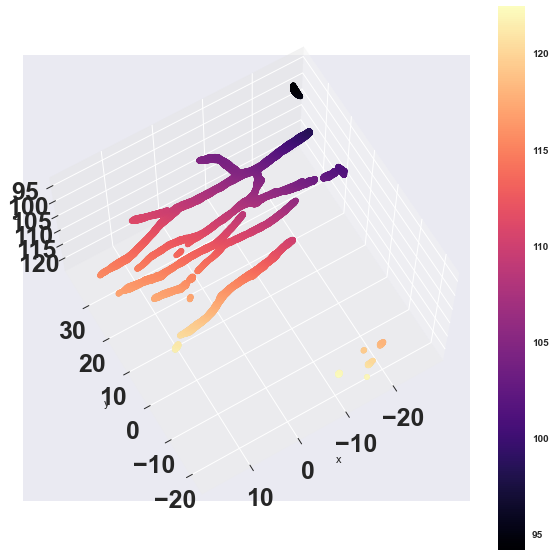

In [791]:
import matplotlib as mpl

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
mpl.style.use('seaborn')


fig = plt.figure(figsize=(10,10))
np.random.seed(11)


ax = fig.add_subplot(111, projection='3d')

c = p3ds[0:,[2]] 
rcParams['font.weight'] = 'bold'
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(25)
        tick.label.set_fontweight('bold')
        
        
p=ax.scatter(p3ds[0:,[0]],p3ds[0:,[1]],p3ds[0:,[2]],c = c, cmap=plt.cm.magma)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

elev = 245.25
azim = 120.5
ax.view_init(elev, azim)


fig.colorbar(p, ax=ax)

fig.savefig("scatter_view_color_bar.png")
plt.show()

# print('ax.azim {}'.format(ax.azim))
# print('ax.elev {}'.format(ax.elev))

# ax.view_init(elev, azim)